In [1]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import readgadget
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm

%load_ext autoreload
%autoreload 2
import bacco
import bacco.probabilistic_bias as pb

Importing pyfftw first


In [2]:
fn_idxs = '../data/idxs_camelssam_in_emu_bounds.dat'
idxs_sam_inbounds = np.loadtxt(fn_idxs, dtype=int)
print(f'{len(idxs_sam_inbounds)} of SAMs have cosmo params in bounds') 
# idx_sam = 12 not working!! first in idxs_sam_inbounds, avoid w this line:
#idxs_sam = idxs_sam_inbounds[1:11]

dir_pbp = '../data/probabilistic_bias_params/bias_params'
idxs_sam = [idx_sam for idx_sam in np.arange(0, 1000) \
            if os.path.isfile(f'{dir_pbp}/bias_params_LH_{idx_sam}.npy')]
idxs_sam.pop(12) # bad for some reason
print(idxs_sam)
print(len(idxs_sam))
    

169 of SAMs have cosmo params in bounds
[12, 16, 17, 18, 20, 28, 48, 52, 58, 65, 70, 79, 88, 98, 113, 116, 118, 131, 142, 146, 148, 157, 160, 161, 167, 168, 172, 176, 180, 182, 195, 197, 212, 214, 224, 232, 238, 243, 253, 258, 260, 262, 267, 268, 272, 277, 279, 284, 287, 289, 290, 296, 299, 313, 318, 319, 332, 341, 342, 345, 355, 362, 365, 366, 370, 372, 374, 385, 389, 390, 409, 424, 429, 431, 439, 441, 443, 444, 456, 459, 461, 476, 484, 488, 489, 518, 522, 523, 536, 537, 540, 543, 552, 554, 557, 558, 560, 567, 570, 574, 578, 600, 601, 602, 609, 619, 627, 639, 646, 648, 663, 667, 671, 681, 682, 688, 691, 694, 697, 699, 704, 713, 715, 717, 724, 728, 731, 734, 746, 748, 749, 769, 774, 780, 782, 786, 791, 798, 805, 807, 810, 811, 815, 818, 822, 828, 841, 855, 856, 858, 864, 867, 884, 888, 895, 896, 898, 903, 905, 931, 946, 948, 966, 969, 976, 980, 981, 987]
168


In [3]:
ndens_target = 0.003
tag_pk = f'_n{ndens_target}_hMpc'
tag_bpfit = '_kmax0.5'
#tag_bpfit = ''

In [4]:
bias_param_names = ['b1', 'b2', 'bl']
# bias_param_names_emu = ['b1', 'b2', 'bs2', 'bl']
# bias_param_names_pb = ['b1', 'b2', 'bdeltal', 'bl', 'bl2']
# idxs_bp_emu = [bias_param_names_emu.index(param_name) for param_name in bias_param_names]
# idxs_bp_pb = [bias_param_names_pb.index(param_name) for param_name in bias_param_names]

In [5]:
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
bounds_dict = {'b1': [-5, 20],
                'b2': [-5, 10],
                'bs2': [-10, 20],
                'bl': [-20, 30],
                'Asn': [0, 2],
                }
bias_param_names_nob1 = bias_param_names.copy()
bias_param_names_nob1.remove('b1')

In [13]:

bp_arr = []
pbp_arr = []
pbp_cov_arr = []
for i, idx_sam in enumerate(idxs_sam):
#for i, idx_sam in enumerate(idxs_sam[:30]):

    fn_bp = f'../data/bias_params/bias_params{tag_pk}{tag_bpfit}/bias_params_LH_{idx_sam}.npy'
    #fn_bp = f'../data/bias_params_bestfit_bltoonarrowbounds/bias_params_LH_{idx_sam}.npy'
    if not os.path.exists(fn_bp):
        print(f"Bias param file {fn_bp} doesn't exist, skipping")
        bp_arr.append([np.nan for bp_name in bias_param_names])
        continue
    
    fn_pbp = f'{dir_pbp}/bias_params_LH_{idx_sam}.npy'
    #fn_bp = f'../data/bias_params_bestfit_bltoonarrowbounds/bias_params_LH_{idx_sam}.npy'
    if not os.path.exists(fn_pbp):
        print(f"Prob bias param file {fn_bp} doesn't exist, skipping")
        pbp_arr.append([np.nan for bp_name in bias_param_names])
        continue
    
    
    bias_params = np.load(fn_bp, allow_pickle=True).item()
    bp_arr.append([bias_params[bp_name] for bp_name in bias_param_names])

    # bs2 is not actually that in pbias!! its bdeltal! not including
    pbias_data = np.load(fn_pbp, allow_pickle=True)
    pbias_params = pbias_data[0]
    
    pbp_arr.append([pbias_params[bp_name] for bp_name in bias_param_names])
    bias_param_names_pb = list(pbias_params.keys())
    idxs_bp_pb = [bias_param_names_pb.index(param_name) for param_name in bias_param_names]
    pbias_cov = pbias_data[1]
    pbp_cov_arr.append([pbias_cov[idx_bp,idx_bp] for idx_bp in idxs_bp_pb])
    
bp_arr = np.array(bp_arr)
pbp_arr = np.array(pbp_arr)
pbp_cov_arr = np.array(pbp_cov_arr)
print(bp_arr.shape)
print(pbp_arr.shape)
print(pbp_cov_arr.shape)

(168, 3)
(168, 3)
(168, 3)


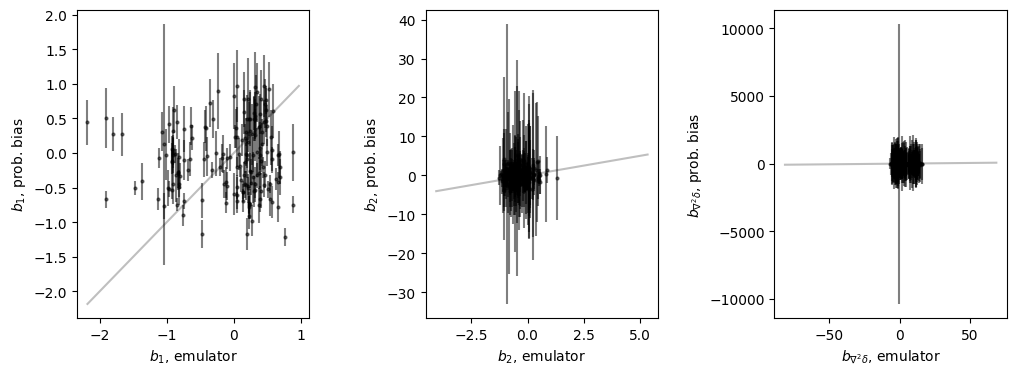

In [18]:
nrows, ncols = 1, 3
fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
plt.subplots_adjust(hspace=0.1, wspace=0.5)

for bb, bp_name in enumerate(bias_param_names):
    xmin = min(np.min(bp_arr[:,bb]), np.min(pbp_arr[:,bb]))
    xmax = max(np.max(bp_arr[:,bb]), np.max(pbp_arr[:,bb]))
    xx = np.linspace(xmin, xmax)
    axarr[bb].plot(xx, xx, color='grey', alpha=0.5)    
    
    #axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
    axarr[bb].errorbar(bp_arr[:,bb], pbp_arr[:,bb], yerr=pbp_cov_arr[:,bb], 
                       marker='o', markersize=2, color='k', ls='None', alpha=0.5)
    axarr[bb].set_xlabel(f'{bias_param_labels[bp_name]}, emulator')
    axarr[bb].set_ylabel(f'{bias_param_labels[bp_name]}, prob. bias')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)